# Telecom Churn

## Objective - Predict which High-Value Customers are at a risk of churn.

1. Retaining High-Value Customers is the primary business objective.
	Sub Goals - 
	a. Recognize the High-Value customers.
	b. Confirm if the customer has churned.
2. The secondary business objective is to determine the features that have a significant effect on a customer Churning.

In [1]:
# Primary Libraries
import numpy as np
import pandas as pd
import warnings 
warnings.simplefilter('ignore')

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tools Libraries
import datetime
import collections

# Model Preparation Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn import metrics

# Handling Imbalance
import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import SMOTE

# Model Libraries
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

0.5.0


In [2]:
churn_df = pd.read_csv("telecom_churn_data.csv")
print('Dataframe Shape: ',churn_df.shape)

Dataframe Shape:  (99999, 226)


**============================================================**

# Identifying and Handling Missing Values

**============================================================**

mobile_number 	Num Missing:  0 	%Missing:  0.0 	Unique Count:  99999
circle_id 	Num Missing:  0 	%Missing:  0.0 	Unique Count:  1
loc_og_t2o_mou 	Num Missing:  1018 	%Missing:  1.018010180101801 	Unique Count:  2
std_og_t2o_mou 	Num Missing:  1018 	%Missing:  1.018010180101801 	Unique Count:  2
loc_ic_t2o_mou 	Num Missing:  1018 	%Missing:  1.018010180101801 	Unique Count:  2
last_date_of_month_6 	Num Missing:  0 	%Missing:  0.0 	Unique Count:  1
last_date_of_month_7 	Num Missing:  601 	%Missing:  0.6010060100601006 	Unique Count:  2
last_date_of_month_8 	Num Missing:  1100 	%Missing:  1.1000110001100012 	Unique Count:  2
last_date_of_month_9 	Num Missing:  1659 	%Missing:  1.6590165901659017 	Unique Count:  2
arpu_6 	Num Missing:  0 	%Missing:  0.0 	Unique Count:  85681
arpu_7 	Num Missing:  0 	%Missing:  0.0 	Unique Count:  85308
arpu_8 	Num Missing:  0 	%Missing:  0.0 	Unique Count:  83615
arpu_9 	Num Missing:  0 	%Missing:  0.0 	Unique Count:  79937
onnet_mou_6 	Num Missing:  3937 

std_ic_t2f_mou_8 	Num Missing:  5378 	%Missing:  5.3780537805378055 	Unique Count:  3052
std_ic_t2f_mou_9 	Num Missing:  7745 	%Missing:  7.745077450774508 	Unique Count:  3091
std_ic_t2o_mou_6 	Num Missing:  3937 	%Missing:  3.937039370393704 	Unique Count:  2
std_ic_t2o_mou_7 	Num Missing:  3859 	%Missing:  3.8590385903859037 	Unique Count:  2
std_ic_t2o_mou_8 	Num Missing:  5378 	%Missing:  5.3780537805378055 	Unique Count:  2
std_ic_t2o_mou_9 	Num Missing:  7745 	%Missing:  7.745077450774508 	Unique Count:  2
std_ic_mou_6 	Num Missing:  3937 	%Missing:  3.937039370393704 	Unique Count:  11647
std_ic_mou_7 	Num Missing:  3859 	%Missing:  3.8590385903859037 	Unique Count:  11890
std_ic_mou_8 	Num Missing:  5378 	%Missing:  5.3780537805378055 	Unique Count:  11663
std_ic_mou_9 	Num Missing:  7745 	%Missing:  7.745077450774508 	Unique Count:  11267
total_ic_mou_6 	Num Missing:  0 	%Missing:  0.0 	Unique Count:  32247
total_ic_mou_7 	Num Missing:  0 	%Missing:  0.0 	Unique Count:  32242

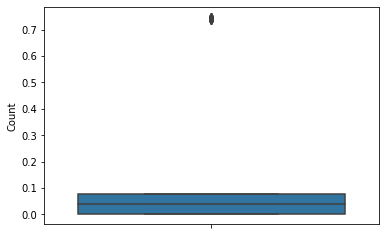

In [3]:
# Identifying Missing Values

# With the below code, we can see that there two groups of missing-value features in the dataset:
# Columns with less than 10% missing values
# columns with more than 70% missing values
# Also, based on the count of unique values, it is more likely for us to find categorical columns from
# Unique Counts < 50
sortCount = pd.DataFrame(churn_df.isnull().sum()/churn_df.shape[0], columns=["Count"]).sort_values(by="Count", ascending=False)
sns.boxplot(y=sortCount["Count"])
#print(sortCount[sortCount["Count"]>=0.7].index.values,'\n\n')

for col in churn_df.columns:
    print(col,'\tNum Missing: ',churn_df[col].isnull().sum(),
          '\t%Missing: ',100*(churn_df[col].isnull().sum())/(churn_df.shape[0]),
          '\tUnique Count: ', len(churn_df[col].unique()))

let's check the output of the churn data. This is done to understand the context of the 70% empty columns:
1. The data dictionary contains meanings of abbreviations. Some frequent ones are loc (local), IC (incoming), OG (outgoing), T2T (telecom operator to telecom operator), T2O (telecom operator to another operator), RECH (recharge) etc.
2. The attributes containing 6, 7, 8, 9 as suffixes imply that those correspond to the months 6, 7, 8, 9 respectively.

As the data is arranged between multiple columns, lets first check what are the unique columns available, so that we can focus if any EDA can be done in total across the dataset.

In [4]:
uniqueColList = [];
for val in churn_df.columns:
    if((val[-1]=="6") or(val[-1]=="7") or(val[-1]=="8") or(val[-1]=="9") ):
        uniqueColList.append(val[:-2])
    elif((val[:3]=="jun") or(val[:3]=="jul") or(val[:3]=="aug") or(val[:3]=="sep") ):
        uniqueColList.append(val[4:])
        
set(uniqueColList)

{'arpu',
 'arpu_2g',
 'arpu_3g',
 'av_rech_amt_data',
 'count_rech_2g',
 'count_rech_3g',
 'date_of_last_rech',
 'date_of_last_rech_data',
 'fb_user',
 'ic_others',
 'isd_ic_mou',
 'isd_og_mou',
 'last_date_of_month',
 'last_day_rch_amt',
 'loc_ic_mou',
 'loc_ic_t2f_mou',
 'loc_ic_t2m_mou',
 'loc_ic_t2t_mou',
 'loc_og_mou',
 'loc_og_t2c_mou',
 'loc_og_t2f_mou',
 'loc_og_t2m_mou',
 'loc_og_t2t_mou',
 'max_rech_amt',
 'max_rech_data',
 'monthly_2g',
 'monthly_3g',
 'night_pck_user',
 'offnet_mou',
 'og_others',
 'onnet_mou',
 'roam_ic_mou',
 'roam_og_mou',
 'sachet_2g',
 'sachet_3g',
 'spl_ic_mou',
 'spl_og_mou',
 'std_ic_mou',
 'std_ic_t2f_mou',
 'std_ic_t2m_mou',
 'std_ic_t2o_mou',
 'std_ic_t2t_mou',
 'std_og_mou',
 'std_og_t2c_mou',
 'std_og_t2f_mou',
 'std_og_t2m_mou',
 'std_og_t2t_mou',
 'total_ic_mou',
 'total_og_mou',
 'total_rech_amt',
 'total_rech_data',
 'total_rech_num',
 'vbc_3g',
 'vol_2g_mb',
 'vol_3g_mb'}

In [5]:
dataNotFound = [];
for val in sortCount[sortCount["Count"]>=0.7].index.values:
    if((val[-1]=="6") or(val[-1]=="7") or(val[-1]=="8") or(val[-1]=="9") ):
        dataNotFound.append(val[:-2])
    elif((val[:3]=="jun") or(val[:3]=="jul") or(val[:3]=="aug") or(val[:3]=="sep") ):
        dataNotFound.append(val[4:])
        
dataNotFound

['arpu_3g',
 'night_pck_user',
 'total_rech_data',
 'arpu_2g',
 'max_rech_data',
 'fb_user',
 'av_rech_amt_data',
 'date_of_last_rech_data',
 'count_rech_2g',
 'count_rech_3g',
 'date_of_last_rech_data',
 'total_rech_data',
 'fb_user',
 'max_rech_data',
 'night_pck_user',
 'count_rech_2g',
 'av_rech_amt_data',
 'arpu_2g',
 'count_rech_3g',
 'arpu_3g',
 'total_rech_data',
 'count_rech_3g',
 'fb_user',
 'max_rech_data',
 'arpu_3g',
 'date_of_last_rech_data',
 'night_pck_user',
 'arpu_2g',
 'count_rech_2g',
 'av_rech_amt_data',
 'total_rech_data',
 'arpu_3g',
 'fb_user',
 'night_pck_user',
 'av_rech_amt_data',
 'max_rech_data',
 'count_rech_3g',
 'arpu_2g',
 'count_rech_2g',
 'date_of_last_rech_data']

We are trying to view overall what columns are present and how much of data is present in the churn_df, just to understand the overall data strength

Created DataFrame - 

ColumnName|Jun|Jul|Aug|Sep|

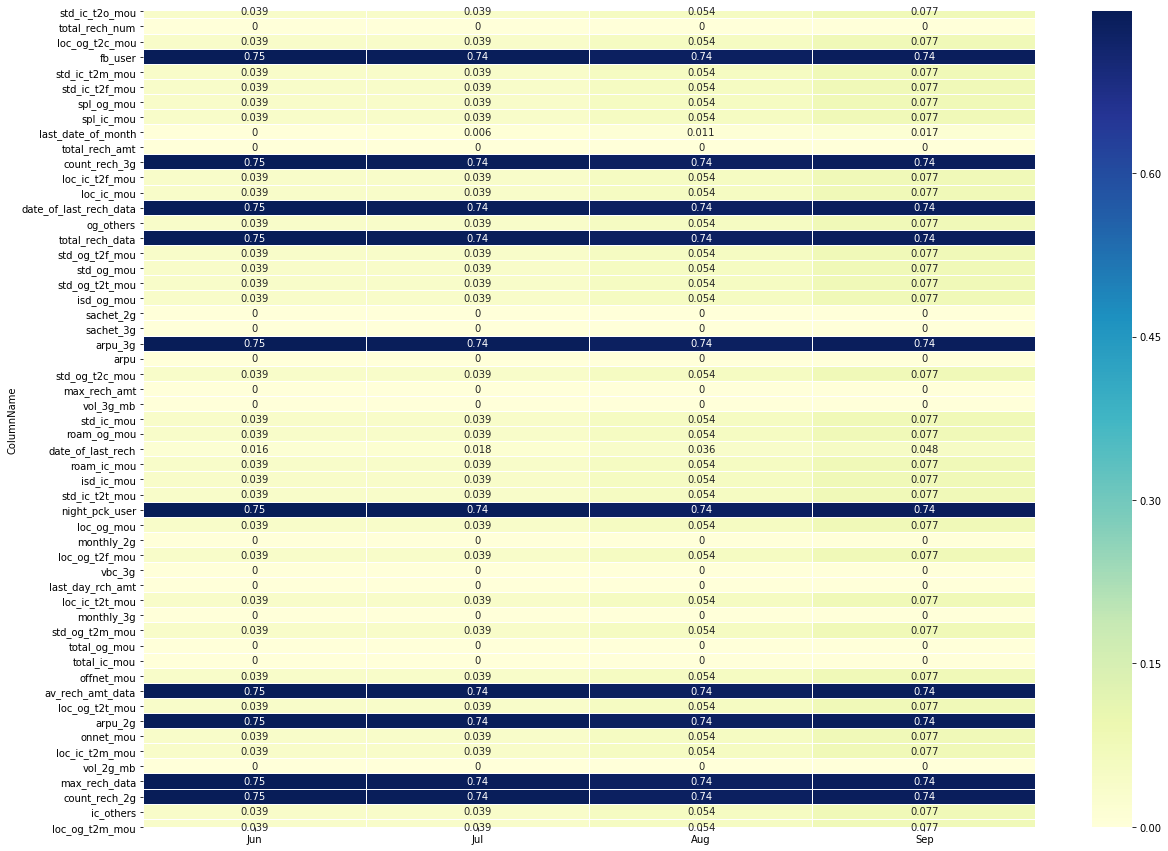

In [6]:
dataStrength_df = pd.DataFrame(columns=["ColumnName", "Jun", "Jul", "Aug", "Sep"])
dataStrength_df["ColumnName"] = list(set(uniqueColList))

primaryColList=["Jun", "Jul", "Aug", "Sep"]
monthList = ["_6", "_7", "_8", "_9"]
startList = ["jun_", "jul_", "aug_", "sep_"]
for val in set(uniqueColList):    
    for index, dat in enumerate(monthList):
        colName1 = val+dat;
        colName2 = startList[index]+val;
        if(colName1 in churn_df.columns.values.tolist()):
            dataStrength_df.loc[dataStrength_df["ColumnName"]==val, primaryColList[index]] = churn_df[colName1].isnull().sum()/churn_df.shape[0]
        elif(colName2 in churn_df.columns.values.tolist()):
            dataStrength_df.loc[dataStrength_df["ColumnName"]==val, primaryColList[index]] = churn_df[colName2].isnull().sum()/churn_df.shape[0]

dataStrength_df.set_index("ColumnName", inplace=True)
dataStrength_df.sort_values(by="ColumnName")

dataStrength_df["Jun"] = dataStrength_df["Jun"].astype("float")
dataStrength_df["Jul"] = dataStrength_df["Jul"].astype("float")
dataStrength_df["Aug"] = dataStrength_df["Aug"].astype("float")
dataStrength_df["Sep"] = dataStrength_df["Sep"].astype("float")

plt.figure(figsize=(20, 15))
sns.heatmap(dataStrength_df, annot=True, linewidths=.1, cmap="YlGnBu")

In [7]:
dataStrength_df.sort_values(["Jun", "Jul", "Aug", "Sep"], ascending=False)

,Jun,Jul,Aug,Sep
ColumnName,,,,
fb_user,0.748467,0.744287,0.736607,0.740777
count_rech_3g,0.748467,0.744287,0.736607,0.740777
date_of_last_rech_data,0.748467,0.744287,0.736607,0.740777
total_rech_data,0.748467,0.744287,0.736607,0.740777
arpu_3g,0.748467,0.744287,0.736607,0.740777
night_pck_user,0.748467,0.744287,0.736607,0.740777
av_rech_amt_data,0.748467,0.744287,0.736607,0.740777
arpu_2g,0.748467,0.744287,0.736607,0.740777
max_rech_data,0.748467,0.744287,0.736607,0.740777


**From this data, below hypothesis can be found:**
1. total_rech_data null data is increasing from Jun to Jul.
2. Wherease teh max_rech_data, Count_rech_3g, av_rech_amt_data, data_of_last_rech_data, fb_user, arpu_3g, count_rech_2g, arpu_2g, night_pck_user null count is decreasing from Jun to Jul.
3. For the rest of the data small quantity of null data is increasing from Jun->Jul->Aug->Sep.

In [8]:
# Rule-of-Thumb: If number of unique values in column < 50 --> Not likely continuous
col_continuous = [col for col in churn_df.columns if len(churn_df[col].unique()) >= 50]
print('Number of (definitely) continuous columns: ', len(col_continuous))

# Uniques < 50
print('\n\nColumns that are likely to have categorical or datetime values: ')
col_unique_50 = [col for col in churn_df.columns if len(churn_df[col].unique()) < 50]
for col in col_unique_50:
    print(col,'\t',churn_df[col].unique())

# circle_id has only 1 unique value, implying that it carries no information that we can use for predictions (no variance)
# The same applies for last_date_of_month_6
drop_list = []
drop_list = ['circle_id']

# MoU columns (Minutes of Usage) are continuous value columns
# These columns having NaN values makes it difficult to assign them any meaningful value
drop_list.extend(['loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou',
                  'std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_og_t2c_mou_9',
                  'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8','std_ic_t2o_mou_9'])

# the June month all the customers are active users.
# Also we can note that for the last_date_of_month_7, last_date_of_month_8, last_date_of_month_9 there are NaN values. 
# This means that the customers could have possibly churned in these given months. 
# Thus lets convert the given columns to possible_churns.
drop_list.extend(['last_date_of_month_6'])
churn_df["possible_churn_7"] = [1 if(val!=val) else 0 for val in churn_df["last_date_of_month_7"]]
churn_df["possible_churn_8"] = [1 if(val!=val) else 0 for val in churn_df["last_date_of_month_8"]]
churn_df["possible_churn_9"] = [1 if(val!=val) else 0 for val in churn_df["last_date_of_month_9"]]

drop_list.extend(["last_date_of_month_7", "last_date_of_month_8", "last_date_of_month_9"])

# Observing the percentage of Churned customers over the months
print("\n\nPercentage of users churning on July - \n", churn_df["possible_churn_7"].value_counts()/churn_df.shape[0])
print("\nPercentage of users churning on August - \n", churn_df["possible_churn_8"].value_counts()/churn_df.shape[0])
print("\nPercentage of users churning on September - \n", churn_df["possible_churn_9"].value_counts()/churn_df.shape[0])

Number of (definitely) continuous columns:  164


Columns that are likely to have categorical or datetime values: 
circle_id 	 [109]
loc_og_t2o_mou 	 [ 0. nan]
std_og_t2o_mou 	 [ 0. nan]
loc_ic_t2o_mou 	 [ 0. nan]
last_date_of_month_6 	 ['6/30/2014']
last_date_of_month_7 	 ['7/31/2014' nan]
last_date_of_month_8 	 ['8/31/2014' nan]
last_date_of_month_9 	 ['9/30/2014' nan]
std_og_t2c_mou_6 	 [nan  0.]
std_og_t2c_mou_7 	 [nan  0.]
std_og_t2c_mou_8 	 [ 0. nan]
std_og_t2c_mou_9 	 [nan  0.]
std_ic_t2o_mou_6 	 [nan  0.]
std_ic_t2o_mou_7 	 [nan  0.]
std_ic_t2o_mou_8 	 [ 0. nan]
std_ic_t2o_mou_9 	 [nan  0.]
date_of_last_rech_6 	 ['6/21/2014' '6/29/2014' '6/17/2014' '6/28/2014' '6/26/2014' '6/19/2014'
 '6/27/2014' '6/25/2014' '6/14/2014' '6/18/2014' '6/20/2014' '6/30/2014'
 '6/23/2014' nan '6/22/2014' '6/24/2014' '6/12/2014' '6/3/2014'
 '6/11/2014' '6/16/2014' '6/10/2014' '6/15/2014' '6/13/2014' '6/7/2014'
 '6/8/2014' '6/6/2014' '6/2/2014' '6/4/2014' '6/5/2014' '6/1/2014'
 '6/9/2014']
date_of_la

There seems to be a loss of customers 
1. July -> August : 0.00499‬
2. August -> September : 0.00559<br>

<b>Overall at the rate of 0.4%</b>

<b>Clearly June & July are the Good phases, August should be the Action phase and September is Churn Phase</b>

Lets mark if the customer is an internet user or a voice user or both

In [9]:
voiceCols = [];
dataCols = [];
voiceKeywords = ["ic", "og", "onnet", "offnet"]
dataKeywords = ["3g", "2g"]
for data in churn_df.columns.values:
    for keywords in voiceKeywords:
        if keywords in data:
            voiceCols.append(data)
    for keywords in dataKeywords:
        if keywords in data:
            dataCols.append(data)
            
# Now we can mark the columns as 
# 1. Customer from which month
# 2. UsedInternet_6, UsedInternet_7, UsedInternet_8, UsedInternet_9
# 3. UsedVoice_6, UsedVoice_7, UsedVoice_8, UsedVoice_9
churn_df["UsedInternet_6"] = [0 if(val == 0) else 1 for val in churn_df[[col for col in dataCols if "_6" in col]].sum(axis=1) ]
churn_df["UsedInternet_7"] = [0 if(val == 0) else 1 for val in churn_df[[col for col in dataCols if "_7" in col]].sum(axis=1) ]
churn_df["UsedInternet_8"] = [0 if(val == 0) else 1 for val in churn_df[[col for col in dataCols if "_8" in col]].sum(axis=1) ]
churn_df["UsedInternet_9"] = [0 if(val == 0) else 1 for val in churn_df[[col for col in dataCols if "_9" in col]].sum(axis=1) ]

churn_df["UsedVoice_6"] = [0 if(val == 0) else 1 for val in churn_df[[col for col in voiceCols if "_6" in col]].sum(axis=1) ]
churn_df["UsedVoice_7"] = [0 if(val == 0) else 1 for val in churn_df[[col for col in voiceCols if "_7" in col]].sum(axis=1) ]
churn_df["UsedVoice_8"] = [0 if(val == 0) else 1 for val in churn_df[[col for col in voiceCols if "_8" in col]].sum(axis=1) ]
churn_df["UsedVoice_9"] = [0 if(val == 0) else 1 for val in churn_df[[col for col in voiceCols if "_9" in col]].sum(axis=1) ]

# Below, we can see if any customers are present who haven't made use of BOTH Internet and Voice-call.
churn_df.loc[((churn_df[["UsedInternet_6", "UsedInternet_7", "UsedInternet_8", "UsedInternet_9"]].sum(axis=1)==0) 
              & (churn_df[["UsedVoice_6", "UsedVoice_7", "UsedVoice_8", "UsedVoice_9"]].sum(axis=1)==0))]

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,possible_churn_8,possible_churn_9,UsedInternet_6,UsedInternet_7,UsedInternet_8,UsedInternet_9,UsedVoice_6,UsedVoice_7,UsedVoice_8,UsedVoice_9
201,7000669827,109,NaN,NaN,NaN,6/30/2014,7/31/2014,8/31/2014,9/30/2014,45.000,...,0,0,0,0,0,0,0,0,0,0
202,7001788209,109,NaN,NaN,NaN,6/30/2014,NaN,NaN,NaN,126.339,...,1,1,0,0,0,0,0,0,0,0
232,7000621478,109,NaN,NaN,NaN,6/30/2014,NaN,8/31/2014,NaN,0.700,...,0,1,0,0,0,0,0,0,0,0
275,7000464930,109,NaN,NaN,NaN,6/30/2014,NaN,NaN,NaN,90.208,...,1,1,0,0,0,0,0,0,0,0
279,7002323802,109,NaN,NaN,NaN,6/30/2014,NaN,8/31/2014,NaN,0.900,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98933,7001771443,109,NaN,NaN,NaN,6/30/2014,NaN,8/31/2014,NaN,0.160,...,0,1,0,0,0,0,0,0,0,0
99383,7002179001,109,NaN,NaN,NaN,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.000,...,0,0,0,0,0,0,0,0,0,0
99856,7001554695,109,NaN,NaN,NaN,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.000,...,0,0,0,0,0,0,0,0,0,0
99978,7000668515,109,NaN,NaN,NaN,6/30/2014,7/31/2014,8/31/2014,NaN,30.000,...,0,1,0,0,0,0,0,0,0,0


<b>These users are basically paying for the services but almost never using it.</b>

In [10]:
# The below users utilize both Voice and Data
churn_df.loc[((churn_df[["UsedInternet_6", "UsedInternet_7", "UsedInternet_8", "UsedInternet_9"]].sum(axis=1)==1) 
              & (churn_df[["UsedVoice_6", "UsedVoice_7", "UsedVoice_8", "UsedVoice_9"]].sum(axis=1)==1))]

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,possible_churn_8,possible_churn_9,UsedInternet_6,UsedInternet_7,UsedInternet_8,UsedInternet_9,UsedVoice_6,UsedVoice_7,UsedVoice_8,UsedVoice_9
276,7000041764,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,210.619,...,0,0,1,0,0,0,1,0,0,0
330,7000994033,109,0.0,0.0,0.0,6/30/2014,NaN,NaN,NaN,56.851,...,1,1,1,0,0,0,1,0,0,0
404,7001658429,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,529.104,...,0,0,1,0,0,0,1,0,0,0
539,7000670087,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,704.033,...,0,0,1,0,0,0,1,0,0,0
1211,7001407305,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,213.819,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99778,7001112677,109,0.0,0.0,0.0,6/30/2014,NaN,NaN,NaN,59.990,...,1,1,1,0,0,0,1,0,0,0
99790,7000008246,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1942.949,...,0,0,1,0,0,0,1,0,0,0
99851,7000565233,109,0.0,0.0,0.0,6/30/2014,NaN,NaN,NaN,446.574,...,1,1,1,0,0,0,1,0,0,0
99996,7000087541,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,229.187,...,0,0,1,0,0,0,1,0,0,0


<b>These are the users who are using both voice and data services</b>

In [11]:
# Determining Old and New Customers
churn_df["customerSince6"] = [6 if(val > 0) else 0 
                              for val in churn_df[[col 
                                                   for col in [dataCols + voiceCols][0] if("6" in col)]].isnull().sum(axis=1)]
churn_df["customerSince7"] = [7 if(val > 0) else 0 
                              for val in churn_df[[col 
                                                   for col in [dataCols + voiceCols][0] if("7" in col)]].isnull().sum(axis=1)]
churn_df["customerSince8"] = [8 if(val > 0) else 0 
                              for val in churn_df[[col 
                                                   for col in [dataCols + voiceCols][0] if("8" in col)]].isnull().sum(axis=1)]
churn_df["customerSince9"] = [9 if(val > 0) else 0 
                              for val in churn_df[[col 
                                                   for col in [dataCols + voiceCols][0] if("9" in col)]].isnull().sum(axis=1)]
# The above columns need to be labeled onto the below single column
churn_df["customerSince"]= 0



def returnCustSince(val):
    #print(val[0])
    if(val[0]!=0):
        return 6;
    elif(val[1]!=0):
        return 7;
    elif(val[2]!=0):
        return 8;
    elif(val[3]!=0):
        return 9;
    else:
        return 0;



churn_df["customerSince"] = churn_df[["customerSince6", "customerSince7", 
                                      "customerSince8", "customerSince9"]].apply(returnCustSince, axis=1)
drop_list.extend(["customerSince6", "customerSince7", "customerSince8", "customerSince9"])
churn_df["customerSince"].value_counts()

6    75439
0    12369
7     6558
8     3310
9     2323
Name: customerSince, dtype: int64

There are some interesting data to be seen, there are customers who have started their services on 7 and then there are users who have paid but probably not used the service.

Now there are other columns ["night_pck_user_6", "night_pck_user_7", "night_pck_user_8", "night_pck_user_9"] and ["fb_user_6", "fb_user_7", "fb_user_8", "fb_user_9"] that have only 2 unique records. Lets analyse and see if any categorical values can be created

In [12]:
print("night_pck_user_6 - ", churn_df["night_pck_user_6"].unique())
print("night_pck_user_7 - ", churn_df["night_pck_user_7"].unique())
print("night_pck_user_8 - ", churn_df["night_pck_user_8"].unique())
print("night_pck_user_9 - ", churn_df["night_pck_user_9"].unique())

print("fb_user_6 - ", churn_df["fb_user_6"].unique())
print("fb_user_7 - ", churn_df["fb_user_7"].unique())
print("fb_user_8 - ", churn_df["fb_user_8"].unique())
print("fb_user_9 - ", churn_df["fb_user_9"].unique())

# Obviously the above columns are showing some categories. 
# fb_user(Extra service for Facebook) = {1:"Yes", 0:"No", nan:"Unknown"}
# night_pck_user(Night Prepaid Service) = {1:"Yes", 0:"No", nan:"Unknown"}
# The above categories mean something, this nothing more would be done on the column
# Lets fill the nan with value 2 to indicate the offer not availed or provided to those customers
churn_df[["night_pck_user_6", "night_pck_user_7", 
          "night_pck_user_8", "night_pck_user_9"]] = churn_df[["night_pck_user_6", "night_pck_user_7", 
                                                               "night_pck_user_8", "night_pck_user_9"]].fillna(2)
churn_df[["fb_user_6", "fb_user_7", 
          "fb_user_8", "fb_user_9"]] = churn_df[["fb_user_6", "fb_user_7", 
                                                 "fb_user_8", "fb_user_9"]].fillna(2)

# arpu_3g_X and arpu_2g_X are the average revenue per user for the customer with 3g and 2g networks. 
# We can get columns that indicate whether the customer is using data or voice calls from the below data. 
# But other than that we can mark the null columns with value of 0
# Fill NaNs of ARPU with 0
churn_df[["arpu_3g_6", "arpu_3g_7", 
          "arpu_3g_8", "arpu_3g_9"]] = churn_df[["arpu_3g_6", "arpu_3g_7", 
                                                 "arpu_3g_8", "arpu_3g_9"]].fillna(0)
churn_df[["arpu_2g_6", "arpu_2g_7", 
          "arpu_2g_8", "arpu_2g_9"]] = churn_df[["arpu_2g_6", "arpu_2g_7", 
                                                 "arpu_2g_8", "arpu_2g_9"]].fillna(0)
# For total_rech_data the NaN values can be replaceed using - 0, 
# as they represent the number of times data-recharge was done by the specific customer
print('\n\nTotal Number of Recharges over the different months: \n',churn_df["total_rech_data_6"].unique())
print(churn_df["total_rech_data_7"].unique())
print(churn_df["total_rech_data_8"].unique())
print(churn_df["total_rech_data_9"].unique())

churn_df[["total_rech_data_6", "total_rech_data_7", 
          "total_rech_data_8", "total_rech_data_9"]] = churn_df[["total_rech_data_6", "total_rech_data_7", 
                                                                 "total_rech_data_8", "total_rech_data_9"]].fillna(0)

# Max Recharge Value of Data for the Given Month
churn_df[["max_rech_data_6", "max_rech_data_7", 
          "max_rech_data_8", "max_rech_data_9"]] = churn_df[["max_rech_data_6", "max_rech_data_7", 
                                                             "max_rech_data_8", "max_rech_data_9"]].fillna(0)

# The Average amount spent by the customer on subscribing to data services
churn_df[["av_rech_amt_data_6", "av_rech_amt_data_7", 
          "av_rech_amt_data_8", "av_rech_amt_data_9"]] = churn_df[["av_rech_amt_data_6", "av_rech_amt_data_7", 
                                                                   "av_rech_amt_data_8", "av_rech_amt_data_9"]].fillna(0)

# Number of 2G/3G recharges done
# Here the data 0 means something, probably the customer was recharging during those times. 
# Thus, we can't mark the empty data as 0, to distinguish between normal customer who were 
# subscribed to 2g or 3g but didn't use the data during that time and customers who were 
# not subscribed to 2g/3g, we will mark the nan as -1
print('\n\n2G Recharges over the different months\n',np.sort(churn_df["count_rech_2g_6"].unique()))
print(np.sort(churn_df["count_rech_2g_7"].unique()))
print(np.sort(churn_df["count_rech_2g_8"].unique()))
print(np.sort(churn_df["count_rech_2g_9"].unique()))

print('\n\n3G Recharges over the different months\n',np.sort(churn_df["count_rech_3g_6"].unique()))
print(np.sort(churn_df["count_rech_3g_7"].unique()))
print(np.sort(churn_df["count_rech_3g_8"].unique()))
print(np.sort(churn_df["count_rech_3g_9"].unique()))

churn_df[["count_rech_3g_6", "count_rech_3g_7", 
          "count_rech_3g_8", "count_rech_3g_9"]] = churn_df[["count_rech_3g_6", "count_rech_3g_7", 
                                                             "count_rech_3g_8", "count_rech_3g_9"]].fillna(value=-1)
churn_df[["count_rech_2g_6", "count_rech_2g_7", 
          "count_rech_2g_8", "count_rech_2g_9"]] = churn_df[["count_rech_2g_6", "count_rech_2g_7", 
                                                             "count_rech_2g_8", "count_rech_2g_9"]].fillna(value=-1)

night_pck_user_6 -  [ 0. nan  1.]
night_pck_user_7 -  [ 0. nan  1.]
night_pck_user_8 -  [ 0. nan  1.]
night_pck_user_9 -  [nan  0.  1.]
fb_user_6 -  [ 1. nan  0.]
fb_user_7 -  [ 1. nan  0.]
fb_user_8 -  [ 1. nan  0.]
fb_user_9 -  [nan  1.  0.]


Total Number of Recharges over the different months: 
 [ 1. nan  3.  5.  4.  2.  6.  8.  7. 12. 16. 11. 10. 14. 20.  9. 18. 29.
 23. 15. 22. 27. 17. 21. 13. 19. 35. 25. 33. 61. 55. 24. 26. 28. 40. 32.
 46. 34.]
[ 1. nan  2.  8.  5. 12.  7.  4.  6.  3. 10. 16. 11.  9. 13. 29. 15. 42.
 17. 14. 23. 22. 20. 19. 21. 32. 25. 18. 26. 24. 48. 35. 30. 27. 43. 31.
 39. 44. 40. 50. 34. 37. 54.]
[ 1.  2. nan  3. 16.  7.  4.  6.  5. 13. 17. 15. 24. 14. 12.  9.  8. 10.
 50. 11. 18. 57. 20. 28. 29. 46. 23. 25. 22. 26. 19. 32. 49. 42. 48. 39.
 40. 34. 44. 27. 38. 21. 30. 33. 60. 37. 55.]
[nan  1.  2.  3.  4.  5.  6.  8.  7. 12.  9. 11. 14. 33. 10. 84. 13. 27.
 32. 20. 18. 19. 24. 16. 21. 26. 15. 30. 17. 41. 38. 40. 31. 52. 22. 23.
 51. 28.]


2G Recharges over

In [13]:
# Onnet and Offnet MoU
# for both the columns below, we can safely pass 0 as the values 
# as the columns mean all kind of calls within/outside the same operator network
# and its minutes of usage - voice calls.
print('Onnet MoU Columns: \n',churn_df[['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9']].head())
print('Offnet MoU Columns: \n',churn_df[['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9']].head())

churn_df[['offnet_mou_6', 'offnet_mou_7', 
          'offnet_mou_8', 'offnet_mou_9']] = churn_df[['offnet_mou_6', 'offnet_mou_7', 
                                                       'offnet_mou_8', 'offnet_mou_9']].fillna(0)
churn_df[['onnet_mou_6','onnet_mou_7', 
          'onnet_mou_8', 'onnet_mou_9']] = churn_df[['onnet_mou_6', 'onnet_mou_7', 
                                                     'onnet_mou_8', 'onnet_mou_9']].fillna(0)

# Roaming MoU (Incoming and Outgoing)
# 
print('\n\nRoaming IC MoU Columns: \n',churn_df[['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9']].head())
print('Roaming OG MoU Columns: \n',churn_df[['roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'roam_og_mou_9']].head())

churn_df[['roam_ic_mou_6', 'roam_ic_mou_7',
          'roam_ic_mou_8', 'roam_ic_mou_9']] = churn_df[['roam_ic_mou_6', 'roam_ic_mou_7',
                                                         'roam_ic_mou_8', 'roam_ic_mou_9']].fillna(0)
churn_df[['roam_og_mou_6', 'roam_og_mou_7', 
          'roam_og_mou_8', 'roam_og_mou_9']] = churn_df[['roam_og_mou_6', 'roam_og_mou_7', 
                                                         'roam_og_mou_8', 'roam_og_mou_9']].fillna(0)

# Local MoU Columns
# Here, all the mou columns have some NaN values, which can be marked as 0 minutes
# This can be extended to all MoU columns
print('\n\nLocal MoU Columns: ',churn_df[['loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 
                                          'loc_og_t2t_mou_9','loc_ic_t2t_mou_6','loc_ic_t2t_mou_7',
                                          'loc_ic_t2t_mou_8','loc_ic_t2t_mou_9']].head())
mouCols = [col for col in churn_df.columns if("mou" in col)] 
churn_df[mouCols] = churn_df[mouCols].fillna(0)
# The same is applied to columns containing '_others_'
othersCols = [col for col in churn_df.columns if("others" in col)] 
churn_df[othersCols] = churn_df[othersCols].fillna(0)

Onnet MoU Columns: 
    onnet_mou_6  onnet_mou_7  onnet_mou_8  onnet_mou_9
0          NaN          NaN         0.00          NaN
1        24.11        78.68         7.68        18.34
2        11.54        55.24        37.26        74.81
3        99.91        54.39       310.98       241.71
4        50.31       149.44        83.89        58.78
Offnet MoU Columns: 
    offnet_mou_6  offnet_mou_7  offnet_mou_8  offnet_mou_9
0           NaN           NaN          0.00           NaN
1         15.74         99.84        304.76         53.76
2        143.33        220.59        208.36        118.91
3        123.31        109.01         71.68        113.54
4         76.96         91.88        124.26         45.81


Roaming IC MoU Columns: 
    roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_ic_mou_9
0            NaN            NaN           0.00            NaN
1            0.0           0.00           0.00           0.00
2            0.0           0.00           0.00          38.49
3        

In [14]:
# Considering the Date Columns
for index, val in list(churn_df.isnull().sum().iteritems()):
    if(val!=0):
        print(index,'\t', val)
        
# last_date_of_month_X has already been handled, and the columns have been included in the drop list
# The remaining date columns are part of the same year, and each column corresponds to the specific month
# The only part of the date columns that has information (variance) is the day-of-month part
for i in ['6','7','8','9','data_6','data_7','data_8','data_9']:
    churn_df["date_of_last_rech_"+i] = pd.to_datetime(churn_df["date_of_last_rech_"+i], format="%m/%d/%Y")
    churn_df['day_of_last_rech_'+i] = churn_df['date_of_last_rech_'+i].dt.day
    churn_df['day_of_last_rech_'+i] = churn_df['day_of_last_rech_'+i].fillna(0)
    churn_df['day_of_last_rech_'+i] = churn_df['day_of_last_rech_'+i].astype("int")
    drop_list.append("date_of_last_rech_"+i)

last_date_of_month_7 	 601
last_date_of_month_8 	 1100
last_date_of_month_9 	 1659
date_of_last_rech_6 	 1607
date_of_last_rech_7 	 1767
date_of_last_rech_8 	 3622
date_of_last_rech_9 	 4760
date_of_last_rech_data_6 	 74846
date_of_last_rech_data_7 	 74428
date_of_last_rech_data_8 	 73660
date_of_last_rech_data_9 	 74077


In [15]:
# Dropping the columns indicated in the drop_list
churn_df = churn_df.drop(drop_list, axis = 1)
churn_df.shape

(99999, 222)

**==========================================================**

## Data Derivation

**==========================================================**

As one of primary distinguishing feature of customers is prepaid and postpaid, Lets create one column to point if that customer is prepaid or postpaid.

In [16]:
for col in churn_df.columns:
    print(col, '\t', churn_df[col].isna().sum())

mobile_number 	 0
arpu_6 	 0
arpu_7 	 0
arpu_8 	 0
arpu_9 	 0
onnet_mou_6 	 0
onnet_mou_7 	 0
onnet_mou_8 	 0
onnet_mou_9 	 0
offnet_mou_6 	 0
offnet_mou_7 	 0
offnet_mou_8 	 0
offnet_mou_9 	 0
roam_ic_mou_6 	 0
roam_ic_mou_7 	 0
roam_ic_mou_8 	 0
roam_ic_mou_9 	 0
roam_og_mou_6 	 0
roam_og_mou_7 	 0
roam_og_mou_8 	 0
roam_og_mou_9 	 0
loc_og_t2t_mou_6 	 0
loc_og_t2t_mou_7 	 0
loc_og_t2t_mou_8 	 0
loc_og_t2t_mou_9 	 0
loc_og_t2m_mou_6 	 0
loc_og_t2m_mou_7 	 0
loc_og_t2m_mou_8 	 0
loc_og_t2m_mou_9 	 0
loc_og_t2f_mou_6 	 0
loc_og_t2f_mou_7 	 0
loc_og_t2f_mou_8 	 0
loc_og_t2f_mou_9 	 0
loc_og_t2c_mou_6 	 0
loc_og_t2c_mou_7 	 0
loc_og_t2c_mou_8 	 0
loc_og_t2c_mou_9 	 0
loc_og_mou_6 	 0
loc_og_mou_7 	 0
loc_og_mou_8 	 0
loc_og_mou_9 	 0
std_og_t2t_mou_6 	 0
std_og_t2t_mou_7 	 0
std_og_t2t_mou_8 	 0
std_og_t2t_mou_9 	 0
std_og_t2m_mou_6 	 0
std_og_t2m_mou_7 	 0
std_og_t2m_mou_8 	 0
std_og_t2m_mou_9 	 0
std_og_t2f_mou_6 	 0
std_og_t2f_mou_7 	 0
std_og_t2f_mou_8 	 0
std_og_t2f_mou_9 	 0
std_og

In [17]:
# Since Postpaid recharges are generally done only once, at the end of the month, 
# or during the last day when the customer decides to churn, or shift to a different plan,
# We can say that total_rech_amt_X == max_rech_amt_X is the first indication of a possible postpaid customer
# The same applies for the Data Recharge side
print('Voice Call\n',churn_df.loc[churn_df["max_rech_amt_6"]==churn_df["total_rech_amt_6"],
             ["max_rech_amt_6", "total_rech_amt_6", "day_of_last_rech_6"]])
print('\n\nData\n',churn_df.loc[churn_df["max_rech_data_6"]==(churn_df["total_rech_data_6"] * churn_df['av_rech_amt_data_6']), 
             ["max_rech_data_6", "total_rech_data_6", "av_rech_amt_data_6", "day_of_last_rech_data_6"]])

# Applying this over the 4 month period yields us an approximately 6000+ number of likely postpaid customers
# It is also important to note that 
# These customers must not be taken into consideration for our analysis as we are tasked with focusing on prepaid customers
temp = churn_df[churn_df['max_rech_amt_6'] == churn_df['total_rech_amt_6']]
temp = temp[temp["max_rech_data_6"]==(temp["total_rech_data_6"] * temp['av_rech_amt_data_6'])]
print(temp.shape)
temp = temp[temp['max_rech_amt_7'] == temp ['total_rech_amt_7']]
temp = temp[temp["max_rech_data_7"]==(temp["total_rech_data_7"] * temp['av_rech_amt_data_7'])]
print(temp.shape)
temp = temp[temp['max_rech_amt_8'] == temp ['total_rech_amt_8']]
temp = temp[temp["max_rech_data_8"]==(temp["total_rech_data_8"] * temp['av_rech_amt_data_8'])]
print(temp.shape)
temp = temp[temp['max_rech_amt_9'] == temp ['total_rech_amt_9']]
temp = temp[temp["max_rech_data_9"]==(temp["total_rech_data_9"] * temp['av_rech_amt_data_9'])]
print(temp.shape)
temp0 = temp[temp['day_of_last_rech_6'] == 0]
temp0 = temp0[temp0['day_of_last_rech_7'] == 0]
temp0 = temp0[temp0['day_of_last_rech_8'] == 0]
temp0 = temp0[temp0['day_of_last_rech_9'] == 0]
temp0 = temp0[temp0['day_of_last_rech_data_6'] == 0]
temp0 = temp0[temp0['day_of_last_rech_data_7'] == 0]
temp0 = temp0[temp0['day_of_last_rech_data_8'] == 0]
temp0 = temp0[temp0['day_of_last_rech_data_9'] == 0]
print('Day 0: ',temp0.shape)
temp31 = temp[temp['day_of_last_rech_6'] == 30]
temp31 = temp31[temp31['day_of_last_rech_7'] == 31]
temp31 = temp31[temp31['day_of_last_rech_8'] == 31]
temp31 = temp31[temp31['day_of_last_rech_9'] == 30]
temp31 = temp31[temp31['day_of_last_rech_data_6'] == 30]
temp31 = temp31[temp31['day_of_last_rech_data_7'] == 31]
temp31 = temp31[temp31['day_of_last_rech_data_8'] == 31]
temp31 = temp31[temp31['day_of_last_rech_data_9'] == 31]
print('Day 30/31: ',temp31.shape)

# Date 30/31 yields no results, and can therefore be ignored

# dropping customers who show postpaid behaviour during the entire 4-month period
idx_list = list(temp0.index)
#idx_list.extend(list(temp31))
#idx_set = set(idx_list)
#print(len(idx_set))
churn_df.drop(idx_list, inplace = True)
print('\n\nNew Dataset size (after removing likely Postpaid Customers): ', churn_df.shape)

Voice Call
        max_rech_amt_6  total_rech_amt_6  day_of_last_rech_6
5                 120               120                  19
7                1580              1580                  27
10                  0                 0                  14
12                110               110                  26
15                  0                 0                  14
...               ...               ...                 ...
99982             154               154                  30
99985              97                97                  16
99993               0                 0                   0
99994              60                60                   3
99995             110               110                  17

[24921 rows x 3 columns]


Data
        max_rech_data_6  total_rech_data_6  av_rech_amt_data_6  \
0                252.0                1.0               252.0   
1                  0.0                0.0                 0.0   
2                  0.0                0

**====================================================================**

# Obtaining Significant Records (HVC)

**====================================================================**

In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.
<br>
We can define high-value customers as follows: 
* Those who have recharged with an amount more than or equal to X
* X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [18]:
# We need to determine all the High Value Customers from the Good Months (June and July)

# Step 1: Obtain the average recharge amount (both call and data) over months 6 and 7
# Columns: total_rech_amt_X, total_rech_data_X, av_rech_amt_data_X
# For data, we can get the total amount for a month by multiplying the average amount of recharge 
# and the total number of times a data recharge was done during that month
total_call_rech = churn_df['total_rech_amt_6'] + churn_df['total_rech_amt_7']
total_data_rech = (churn_df['total_rech_data_6'] 
                   * churn_df['av_rech_amt_data_6']) + (churn_df['total_rech_data_7'] 
                                                        * churn_df['av_rech_amt_data_7'])

churn_df['avg_rech_good_months'] = 0.5*(total_call_rech + total_data_rech)

# 70th percentile Amount
rech_70 = churn_df['avg_rech_good_months'].quantile(0.7)

# Filter
# This section needs to be rechecked
# (>= 0.7) gives 30001 records
# (> 0.7) gives 29953 records
churn_df = churn_df[churn_df['avg_rech_good_months'] >= rech_70]
print('Shape after HVC filtering: ',churn_df.shape)

Shape after HVC filtering:  (30001, 223)


**====================================================================**

# Churn Labeling

**====================================================================**

In [19]:
# 0 calls AND 0 MB data --> Churn
# Usage-Based Churn occurs when a customer does not make an Incoming/Outgoing call during the month
# and has not made use of 2G/3G services
# Columns to consider: ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']

churn_df['Churn'] = np.nan
for i in list(churn_df.index):
    cond1 = round(churn_df['total_ic_mou_9'][i] + churn_df['total_og_mou_9'][i])
    cond2 = round(churn_df['vol_2g_mb_9'][i] + churn_df['vol_3g_mb_9'][i])
    if (cond1 == 0) & (cond2 == 0):
        churn_df['Churn'][i] = 1
    else:
        churn_df['Churn'][i] = 0

print(churn_df['Churn'].head())
print(churn_df.shape)

0     1.0
7     1.0
8     0.0
21    0.0
23    0.0
Name: Churn, dtype: float64
(30001, 224)


After tagging churners, we remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [20]:
# Drop All September columns
# Both _9 and sep_

churn_df = churn_df.drop([col for col in churn_df.columns if '_9' in col], axis = 1)
churn_df = churn_df.drop([col for col in churn_df.columns if 'sep_' in col], axis = 1)
print(churn_df.shape)
for col in churn_df.columns:
    print(col)

(30001, 169)
mobile_number
arpu_6
arpu_7
arpu_8
onnet_mou_6
onnet_mou_7
onnet_mou_8
offnet_mou_6
offnet_mou_7
offnet_mou_8
roam_ic_mou_6
roam_ic_mou_7
roam_ic_mou_8
roam_og_mou_6
roam_og_mou_7
roam_og_mou_8
loc_og_t2t_mou_6
loc_og_t2t_mou_7
loc_og_t2t_mou_8
loc_og_t2m_mou_6
loc_og_t2m_mou_7
loc_og_t2m_mou_8
loc_og_t2f_mou_6
loc_og_t2f_mou_7
loc_og_t2f_mou_8
loc_og_t2c_mou_6
loc_og_t2c_mou_7
loc_og_t2c_mou_8
loc_og_mou_6
loc_og_mou_7
loc_og_mou_8
std_og_t2t_mou_6
std_og_t2t_mou_7
std_og_t2t_mou_8
std_og_t2m_mou_6
std_og_t2m_mou_7
std_og_t2m_mou_8
std_og_t2f_mou_6
std_og_t2f_mou_7
std_og_t2f_mou_8
std_og_mou_6
std_og_mou_7
std_og_mou_8
isd_og_mou_6
isd_og_mou_7
isd_og_mou_8
spl_og_mou_6
spl_og_mou_7
spl_og_mou_8
og_others_6
og_others_7
og_others_8
total_og_mou_6
total_og_mou_7
total_og_mou_8
loc_ic_t2t_mou_6
loc_ic_t2t_mou_7
loc_ic_t2t_mou_8
loc_ic_t2m_mou_6
loc_ic_t2m_mou_7
loc_ic_t2m_mou_8
loc_ic_t2f_mou_6
loc_ic_t2f_mou_7
loc_ic_t2f_mou_8
loc_ic_mou_6
loc_ic_mou_7
loc_ic_mou_8
std_ic_

**========================================================**

# Additional EDA

**========================================================**

In [21]:
# We can aggregate the features of all Good Months (6,7)

# Recreate the unique column list for continuous features
uniqueColList = [];
for val in churn_df[[col for col in churn_df.columns if len(churn_df[col].unique()) >= 33]].columns:
    if((val[-1]=="6") or(val[-1]=="7") or(val[-1]=="8") or(val[-1]=="9") ):
        uniqueColList.append(val[:-2])
    '''elif((val[:3]=="jun") or(val[:3]=="jul") or(val[:3]=="aug") or(val[:3]=="sep") ):
        uniqueColList.append(val[4:])'''

unique_col_list = list(set(uniqueColList))
#print(unique_col_list)

for col in unique_col_list:
    churn_df[col+'_GoodMonths_total'] = churn_df[col+'_6'] + churn_df[col+'_7']
    churn_df[col+'_GoodMonths_change'] = churn_df[col+'_6'] - churn_df[col+'_7']
    churn_df[col+'_GoodMonths_average'] = (churn_df[col+'_6'] + churn_df[col+'_7'])*0.5
    churn_df[col+'_GoodMonths_max'] = churn_df[[col+'_6',col+'_7']].max(axis = 1)

print(churn_df.shape)

(30001, 341)


**===============================================================**

# Modelling

**===============================================================**

The predictive models that we’re going to build will serve two purposes:

1. It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.

2. It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

Create train and test data for running different models

In [22]:
y = churn_df['Churn']
X = churn_df.drop('Churn',axis = 1)
print(X.shape, y.shape)

# Set up the training, validation and test sets
# 20% of the dataset is test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42) 

print(X_train.shape, X_test.shape)

(30001, 340) (30001,)
(21000, 340) (9001, 340)


In [23]:
# Applying Scaling to the continuous valued columns and to months
scaler = MinMaxScaler();
X_train[[col for col in churn_df.columns if len(churn_df[col].unique()) > 3]] = scaler.fit_transform(X_train[[col for col in churn_df.columns if len(churn_df[col].unique()) > 3]])
X_test[[col for col in churn_df.columns if len(churn_df[col].unique()) > 3]] = scaler.transform(X_test[[col for col in churn_df.columns if len(churn_df[col].unique()) > 3]])
print('Scaling has been applied')

Scaling has been applied


In [24]:
# Applying SMOTE after scaling has already been done
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 1763
Before OverSampling, counts of label '0': 19237 

After OverSampling, the shape of train_X: (38474, 340)
After OverSampling, the shape of train_y: (38474,) 

After OverSampling, counts of label '1': 19237
After OverSampling, counts of label '0': 19237


### Lasso regression + Logistic Regression

In [25]:
%%time
# grid search CV

# set up cross validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 1.0, 5.0, 10.0]}

# grid search
# lasso model
model = Lasso()
model_cv = GridSearchCV(estimator = model, param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True, verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   51.4s finished


Wall time: 58.1 s


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 1.0, 5.0, 10.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

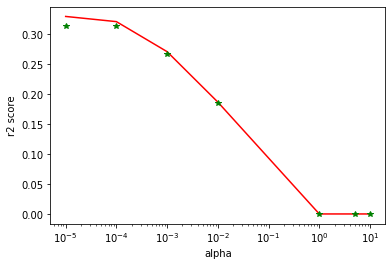

In [26]:
cv_results = pd.DataFrame(model_cv.cv_results_)
# plot
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], 'r-')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], 'g*')
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

In [27]:
# model with optimal alpha
# lasso regression
lm = Lasso(alpha=0.0001)
lm.fit(X_train, y_train)

# lasso model parameters
model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
sorted(list(zip(cols, model_parameters)), key=(lambda x: x[1]))

colsWithValues = pd.DataFrame(list(zip(cols, model_parameters)))
selectedColumns = colsWithValues.loc[((colsWithValues[1]!=0) & (colsWithValues[0]!="constant")), 0].values.tolist()
colsWithValues.loc[((colsWithValues[1]!=0) & (colsWithValues[0]!="constant"))].sort_values(by=1).values.tolist()

[['total_og_mou_8', -0.878],
 ['last_day_rch_amt_8', -0.483],
 ['UsedVoice_8', -0.476],
 ['total_ic_mou_8', -0.392],
 ['total_rech_num_8', -0.323],
 ['day_of_last_rech_8', -0.162],
 ['spl_ic_mou_8', -0.158],
 ['std_og_mou_8', -0.151],
 ['last_day_rch_amt_7', -0.11],
 ['loc_og_t2m_mou_6', -0.106],
 ['aon', -0.054],
 ['fb_user_8', -0.037],
 ['max_rech_data_6', -0.032],
 ['UsedInternet_8', -0.032],
 ['monthly_2g_6', -0.028],
 ['std_og_t2t_mou_8', -0.023],
 ['max_rech_data_8', -0.02],
 ['night_pck_user_7', -0.01],
 ['day_of_last_rech_data_8', -0.009],
 ['monthly_2g_7', -0.007],
 ['fb_user_6', 0.004],
 ['day_of_last_rech_6', 0.005],
 ['day_of_last_rech_data_6', 0.006],
 ['total_rech_data_GoodMonths_max', 0.012],
 ['UsedInternet_6', 0.012],
 ['sachet_2g_6', 0.015],
 ['UsedInternet_7', 0.016],
 ['night_pck_user_8', 0.018],
 ['possible_churn_7', 0.018],
 ['fb_user_7', 0.025],
 ['vol_2g_mb_GoodMonths_max', 0.031],
 ['UsedVoice_6', 0.031],
 ['sachet_3g_7', 0.032],
 ['sachet_2g_GoodMonths_max', 0

In [28]:
lm_pred = lm.predict(X_test).round()
cm = metrics.confusion_matrix(y_test,lm_pred)
print('Accuracy: ',metrics.accuracy_score(y_test,lm_pred))
print('CM (%)\n', 100*cm/X_test.shape[0])
print('Sensitivity: ', cm[1,1]/(cm[1,0]+cm[1,1]))
# Lasso Regression is being affected adversely by the imbalance in the 'Churn' column
# Therefore, it suffers from low sensitivity

Accuracy:  0.9363404066214865
CM (%)
 [[91.15653816  0.87768026]
 [ 5.48827908  2.4775025 ]]
Sensitivity:  0.3110181311018131


In [29]:
# Lasso Regression Predictions with SMOTE
lm_res = Lasso(alpha=0.0001)
lm_res.fit(X_train_res, y_train_res)

lm_res_pred = lm_res.predict(X_test)
lm_res_pred[lm_res_pred>0.5]=1
lm_res_pred[lm_res_pred<=0.5]=0
cm = metrics.confusion_matrix(y_test,lm_res_pred)
print('Accuracy: ',metrics.accuracy_score(y_test,lm_res_pred))
print('CM (%)\n', 100*cm/X_test.shape[0])
print('Sensitivity: ', cm[1,1]/(cm[1,0]+cm[1,1]))
# The accuracy has decreased; However, the Sensitivity to Churn has increased significantly (86.6%)

Accuracy:  0.8321297633596267
CM (%)
 [[76.31374292 15.7204755 ]
 [ 1.06654816  6.89923342]]
Sensitivity:  0.8661087866108786


In [30]:
# lasso model parameters for SMOTE
model_parameters = list(lm_res.coef_)
model_parameters.insert(0, lm_res.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
sorted(list(zip(cols, model_parameters)), key=(lambda x: x[1]))

colsWithValues = pd.DataFrame(list(zip(cols, model_parameters)))
selectedColumns = colsWithValues.loc[((colsWithValues[1]!=0) & (colsWithValues[0]!="constant")), 0].values.tolist()
colsWithValues.loc[((colsWithValues[1]!=0) & (colsWithValues[0]!="constant"))].sort_values(by=1).values.tolist()

[['total_og_mou_8', -2.259],
 ['last_day_rch_amt_8', -1.802],
 ['spl_ic_mou_8', -1.288],
 ['total_ic_mou_8', -1.28],
 ['total_rech_num_8', -1.156],
 ['last_day_rch_amt_7', -0.358],
 ['loc_og_t2m_mou_8', -0.341],
 ['loc_ic_t2m_mou_8', -0.269],
 ['loc_og_mou_6', -0.26],
 ['spl_og_mou_8', -0.255],
 ['day_of_last_rech_8', -0.235],
 ['loc_og_t2m_mou_6', -0.221],
 ['UsedVoice_8', -0.21],
 ['vol_2g_mb_8', -0.202],
 ['aon', -0.202],
 ['max_rech_data_GoodMonths_max', -0.195],
 ['std_og_t2f_mou_8', -0.178],
 ['UsedVoice_6', -0.159],
 ['monthly_2g_6', -0.152],
 ['loc_ic_t2f_mou_8', -0.151],
 ['day_of_last_rech_data_8', -0.125],
 ['max_rech_data_8', -0.116],
 ['std_ic_t2m_mou_GoodMonths_total', -0.094],
 ['aug_vbc_3g', -0.093],
 ['fb_user_8', -0.091],
 ['UsedInternet_8', -0.088],
 ['loc_ic_mou_8', -0.081],
 ['possible_churn_8', -0.079],
 ['monthly_2g_7', -0.076],
 ['loc_ic_t2f_mou_6', -0.069],
 ['offnet_mou_GoodMonths_change', -0.059],
 ['night_pck_user_7', -0.026],
 ['std_og_t2f_mou_GoodMonths_to

In [31]:
# Observing Logistic Regression on the dataset
lr = LogisticRegression()
lr.fit(X_train, y_train)
lrPredictions = lr.predict(X_test)

cm = metrics.confusion_matrix(y_test,lrPredictions)
print('Accuracy: ',metrics.accuracy_score(y_test,lrPredictions))
print('\nConfusion Matrix (%):\n',100*cm/X_test.shape[0])
print('\nSensitivity: ', cm[1,1]/(cm[1,0]+cm[1,1]))
# We can see that Logistic Regression does not perform very well against the Churned Records due to the imbalance

Accuracy:  0.9388956782579714

Confusion Matrix (%):
 [[91.05654927  0.97766915]
 [ 5.13276303  2.83301855]]

Sensitivity:  0.35564853556485354


In [32]:
# Logistic Regression Predictions with SMOTE
lr_res = LogisticRegression()
lr_res.fit(X_train_res, y_train_res)
lr_pred_res = lr_res.predict(X_test)

cm = metrics.confusion_matrix(y_test,lr_pred_res)
print('Accuracy: ',metrics.accuracy_score(y_test,lr_pred_res))
print('CM (%)\n', 100*cm/X_test.shape[0])
print('Sensitivity: ', cm[1,1]/(cm[1,0]+cm[1,1]))
# The accuracy has decreased; However, the Sensitivity to Churn has increased significantly (86.19%)

Accuracy:  0.8429063437395845
CM (%)
 [[77.42473059 14.60948783]
 [ 1.09987779  6.86590379]]
Sensitivity:  0.8619246861924686


# PCA

In [33]:
from sklearn.decomposition import PCA

In [34]:
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(X_train)
# View the PCA component vectors
print('Principal Components:\n',pca.components_)

colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
print(pcs_df.head(10))

Principal Components:
 [[-1.85240608e-03 -1.43292684e-03 -1.02080966e-03 ... -6.58625342e-05
  -3.63473409e-03 -3.75239033e-03]
 [ 5.23955869e-03  2.27081778e-04  1.48740818e-03 ... -8.35230961e-04
   5.01459184e-03  5.18020001e-03]
 [ 6.78827832e-04  2.24101509e-03 -8.21052848e-04 ...  1.32760983e-03
   2.01295460e-03  1.96862980e-03]
 ...
 [-0.00000000e+00 -1.01457653e-18 -4.78888183e-19 ... -1.93959056e-18
   2.56616832e-18 -2.85070593e-18]
 [ 0.00000000e+00 -2.61909589e-19  1.02015629e-18 ...  1.57557681e-18
   7.66780089e-19 -2.41738953e-18]
 [ 0.00000000e+00 -2.87833001e-03  2.12578140e-03 ...  3.60960552e-02
   9.02657325e-03 -1.11889664e-16]]
        PC1       PC2        Feature
0 -0.001852  0.005240  mobile_number
1 -0.001433  0.000227         arpu_6
2 -0.001021  0.001487         arpu_7
3 -0.000658  0.002951         arpu_8
4 -0.008502  0.003600    onnet_mou_6
5 -0.007781  0.005017    onnet_mou_7
6 -0.005007  0.005101    onnet_mou_8
7 -0.010029  0.006459   offnet_mou_6
8 -0.007

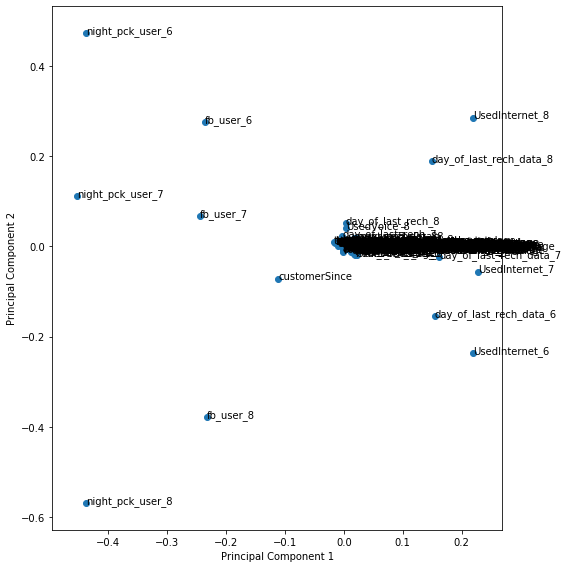

In [35]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

Here the maximum variance are present in below columns:
1. night_pck_user_X
2. UsedInternet_X
3. day_of_last_rech_data_X
4. fb_user_X
5. customerSince

In [36]:
pca.explained_variance_ratio_

array([6.00566766e-01, 1.27133033e-01, 9.30715891e-02, 1.77551648e-02,
       1.68757531e-02, 1.60187698e-02, 1.24626309e-02, 1.00431892e-02,
       8.69828844e-03, 8.15119180e-03, 6.91779196e-03, 6.19721861e-03,
       5.55910649e-03, 5.40068026e-03, 4.62854863e-03, 4.56987036e-03,
       3.75906101e-03, 3.49019571e-03, 3.28407901e-03, 3.18993410e-03,
       2.65947586e-03, 2.57275437e-03, 2.46351602e-03, 2.11478655e-03,
       1.97639688e-03, 1.68596188e-03, 1.66849050e-03, 1.55120937e-03,
       1.48440856e-03, 1.40333225e-03, 1.27519531e-03, 1.13434095e-03,
       1.05838962e-03, 8.75221189e-04, 8.47173568e-04, 7.65431467e-04,
       7.49163744e-04, 7.13022636e-04, 7.00946038e-04, 6.51514650e-04,
       6.02243427e-04, 6.00756765e-04, 5.82397537e-04, 5.52828814e-04,
       5.18497973e-04, 5.04900850e-04, 4.76458044e-04, 4.41341170e-04,
       4.16237217e-04, 3.80906384e-04, 3.77192750e-04, 3.64470027e-04,
       3.49802683e-04, 3.46678040e-04, 3.15965487e-04, 2.96154485e-04,
      

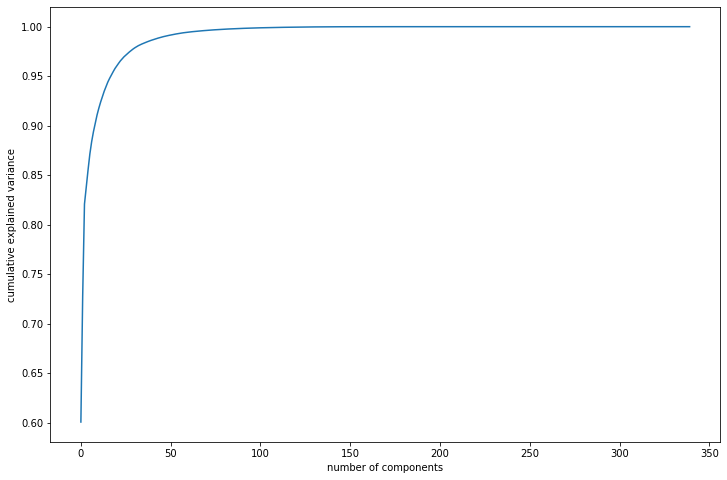

In [37]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

The variance is reaching 90% almost at 15 to 20 components. Will consider 20 number of components for initial analysis.

In [38]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=20)

In [39]:
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(21000, 20)

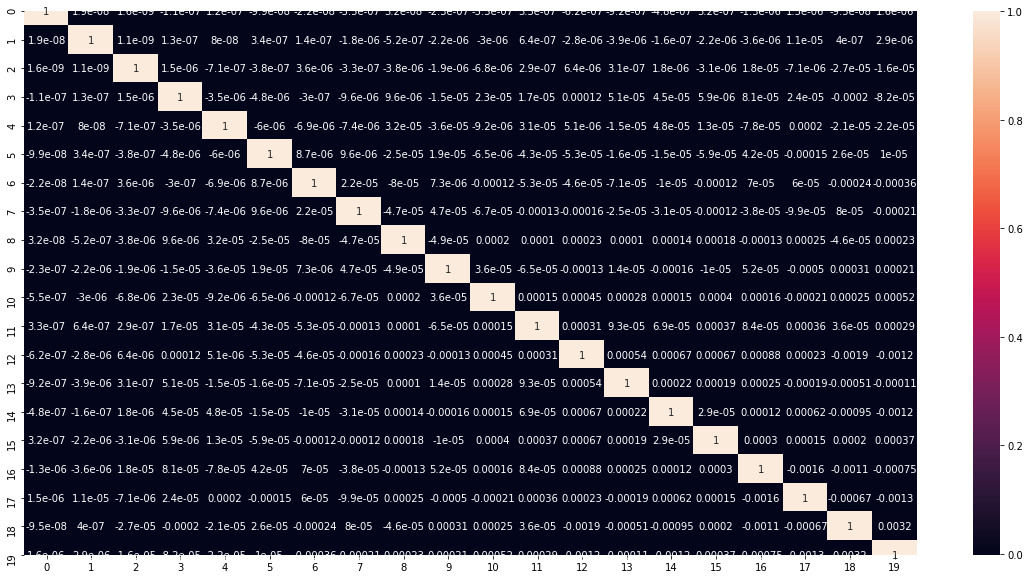

In [40]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

#Plotting the correlation matrix
# This is to prove that the PCs have near-zero correlation
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [41]:
#Applying selected components to the test data - 20 components
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(9001, 20)

In [42]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_train)

In [43]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.88'

In [44]:
print('CM (%): \n', 100*metrics.confusion_matrix(y_test,model_pca.predict(df_test_pca))/X_test.shape[0])
# SMOTE Definitely needs to be applied; Poor Sensitivity

CM (%): 
 [[91.16764804  0.86657038]
 [ 5.55493834  2.41084324]]


## PCA with SMOTE

Principal Components:
 [[-8.00442534e-04 -1.84645729e-03 -8.57315483e-04 ... -3.97172350e-04
  -1.33023214e-03 -1.62178172e-03]
 [ 1.25233859e-02  1.98474231e-04  2.37334207e-03 ... -1.59459591e-03
   5.12062280e-03  4.90181324e-03]
 [ 1.13271963e-02  2.71105267e-03 -1.33676290e-03 ...  2.10471968e-03
   1.43244746e-03  1.76659737e-03]
 ...
 [-0.00000000e+00 -9.20386777e-18  2.68991680e-18 ...  1.12728669e-18
  -4.39514094e-18 -6.31533302e-19]
 [ 0.00000000e+00 -9.76776505e-18 -3.19339013e-18 ... -4.73967343e-18
   5.81292122e-18  7.24826389e-20]
 [ 0.00000000e+00  8.48525005e-18  1.74683878e-17 ...  5.89137498e-19
  -5.39909151e-18 -3.09208372e-19]]
        PC1       PC2        Feature
0 -0.000800  0.012523  mobile_number
1 -0.001846  0.000198         arpu_6
2 -0.000857  0.002373         arpu_7
3  0.000142  0.004101         arpu_8
4 -0.010202  0.006408    onnet_mou_6
5 -0.007652  0.008329    onnet_mou_7
6 -0.002819  0.006732    onnet_mou_8
7 -0.010602  0.006946   offnet_mou_6
8 -0.006

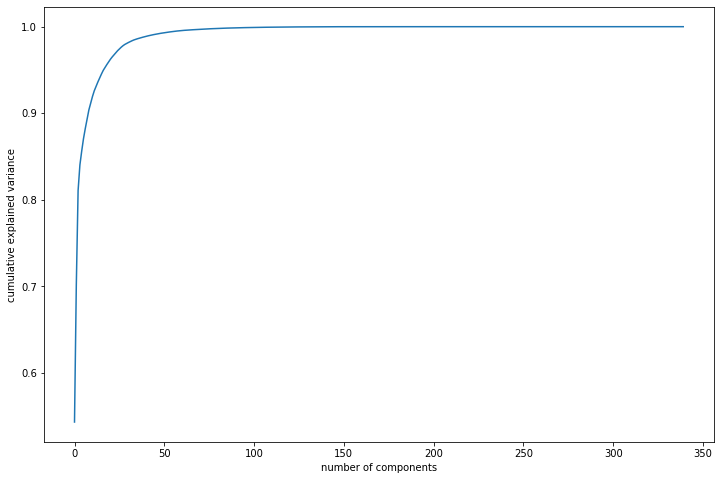

In [45]:
pca_res = PCA(svd_solver='randomized', random_state=42)
pca_res.fit(X_train_res)
# View the PCA component vectors
print('Principal Components:\n',pca_res.components_)

colnames = list(X_train.columns)
pcs_res_df = pd.DataFrame({'PC1':pca_res.components_[0],'PC2':pca_res.components_[1], 'Feature':colnames})
print(pcs_res_df.head(10))

#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca_res.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [46]:
# PCA with SMOTE
pca_res_final = IncrementalPCA(n_components=25)
df_train_pca_res = pca_res_final.fit_transform(X_train_res)
df_test_pca_res = pca_res_final.transform(X_test)

learner_pca_res = LogisticRegression()
model_pca_res = learner_pca_res.fit(df_train_pca_res,y_train_res)

lr_pred_pca_res = model_pca_res.predict(df_test_pca_res)

cm = metrics.confusion_matrix(y_test,lr_pred_pca_res)
print('Accuracy: ',metrics.accuracy_score(y_test,lr_pred_pca_res))
print('CM (%)\n', 100*cm/X_test.shape[0])
print('Sensitivity: ', cm[1,1]/(cm[1,0]+cm[1,1]))
# The accuracy has decreased significantly to 77%; 
#However, the Sensitivity to Churn is (79.9%)

Accuracy:  0.7708032440839907
CM (%)
 [[70.71436507 21.31985335]
 [ 1.59982224  6.36595934]]
Sensitivity:  0.799163179916318


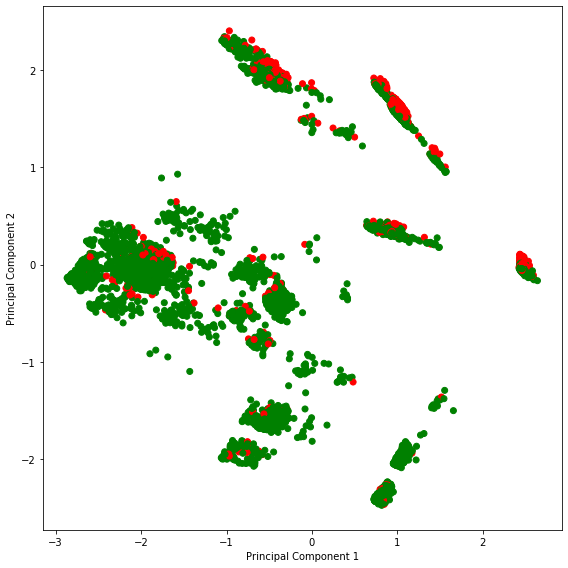

In [47]:
%matplotlib inline

# No SMOTE
fig = plt.figure(figsize = (8,8))
plt.scatter(df_train_pca[:,0], df_train_pca[:,1], c = y_train.map({0:'green',1:'red'}))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

In [48]:
# Random Forest for the Selection of Features
from sklearn.ensemble import RandomForestClassifier

In [49]:
%%time
# With SMOTE
rf_res = RandomForestClassifier(n_estimators=300,oob_score=True,max_features=25)
rf_res.fit(X_train_res, y_train_res)
rf_res_pred = rf_res.predict(X_test)

cm = metrics.confusion_matrix(y_test,rf_res_pred)
print('Accuracy: ',metrics.accuracy_score(y_test,rf_res_pred))
print('CM (%)\n', 100*cm/X_test.shape[0])
print('Sensitivity: ', cm[1,1]/(cm[1,0]+cm[1,1]))

Accuracy:  0.9347850238862349
CM (%)
 [[88.26797023  3.76624819]
 [ 2.75524942  5.21053216]]
Sensitivity:  0.6541143654114365
Wall time: 4min


In [50]:
imp_feats = rf_res.feature_importances_
indices = np.argsort(imp_feats)[::-1]

# Print the feature ranking
print("Feature ranking:")
col_list = list(X_train.columns)

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, col_list[indices[f]], imp_feats[indices[f]]))

Feature ranking:
1. feature roam_og_mou_8 (0.047529)
2. feature roam_ic_mou_8 (0.047058)
3. feature customerSince (0.046681)
4. feature total_ic_mou_8 (0.043357)
5. feature loc_ic_mou_8 (0.043035)
6. feature day_of_last_rech_8 (0.041888)
7. feature loc_ic_t2m_mou_8 (0.041718)
8. feature total_rech_amt_8 (0.024070)
9. feature loc_ic_t2t_mou_8 (0.022658)
10. feature last_day_rch_amt_8 (0.022404)
11. feature loc_og_t2m_mou_8 (0.020790)
12. feature max_rech_amt_8 (0.019283)
13. feature loc_og_mou_8 (0.019198)
14. feature arpu_8 (0.018888)
15. feature total_og_mou_8 (0.015120)
16. feature loc_og_t2t_mou_8 (0.013051)
17. feature av_rech_amt_data_8 (0.010901)
18. feature day_of_last_rech_data_8 (0.010529)
19. feature loc_ic_t2f_mou_8 (0.009527)
20. feature total_rech_num_8 (0.008648)
21. feature max_rech_data_8 (0.008633)
22. feature UsedVoice_8 (0.007726)
23. feature offnet_mou_8 (0.006634)
24. feature total_rech_data_8 (0.006491)
25. feature count_rech_2g_8 (0.005977)
26. feature std_ic_mou

## Results

**From the analysis the below variables are useful for Telecom Churn**
* Based on Lasso Regression:
    1. Total Outgoing M.o.U (Action Month)
    2. The Rechanrg Amount Applied on the Last Day (Action Month)
    3. Total Incoming M.o.U (Action Month)
    4. Total Number of Times the Recharge was done (Action Month)
    5. Total Outgoing/Incoming M.o.U (Good Months - Max value)

* Based on Random Forest:
    1. Roaming Incoming / Outgoing M.o.U for the Action Month
    2. The CustomerSince (Age of Network)
    3. Local Calls (Incoming / Outgoing) in the Action Month
    4. The Amount on Data Recharge for the Action Month
    5. ARPU for the Action Month

In [70]:
# 2480
temp = churn_df[churn_df['Churn'] == 1]
# 795 (7 to 8); 662 (6 to 7)
print(temp[temp['total_rech_data_6'] > temp['total_rech_data_7']].shape)
print(temp[temp['total_rech_data_7'] > temp['total_rech_data_8']].shape)
print(temp[temp['total_rech_data_6'] > temp['total_rech_data_8']].shape)

(662, 341)
(795, 341)
(975, 341)


<b>Among these variables the most important indicators of churning would be </b>
1. If customer has used Voice/Internet in the Action Month, as indicated by the various Minutes-of-Usage features; The greater the value is, the less the chance of Churn.
2. AON i.e Age of network also plays a very important role in the churn. The longer the user has been a subscriber to the telecom services, the less likely that user is to Churn.
3. ARPU during the action month is inversely related to Churn, as can be expected. Higher ARPU Users are customers who make good use of all packages offered by the telecom provider.
4. A reduction in the number of times a data recharge is done in a month over multiple months is a sign of possible Churn.

# Conclusion

* The drill-down would begin with the high ARPU generating users, especially those where the ARPU is steadily decreasing over time.
* The major reasons for Churn appears to be a reduction in the Minutes-of-Usage of Incoming/Outgoing Calls, especially for the case of Roaming Calls and Local Calls. This may be because of the low quality of service that some users may face for Roaming Calls, and possibly High Network Congestion for Local Calls. Improving these services may help prevent Churn.
* The number of times a user applies for a recharge for data steadily decreases over the months if the user has a higher possibility of churning. The likely reasons are the quality of service in connection to data, especially the structure and pricing of the data package. Changing the scheme of data usage and reasonable signal quality in different netwok regions are likely to reduce the rate of Churn.